In [2]:
import numpy as np
from math import sin, cos, pi
import matplotlib.pyplot as plt
from scipy.stats import qmc
import yfinance as yf
from datetime import datetime
# from multiprocessing import Pool
from es import CMAES

%matplotlib widget

['QQQ', '2023-10-25', '2023-11-25', '2m']: 2828


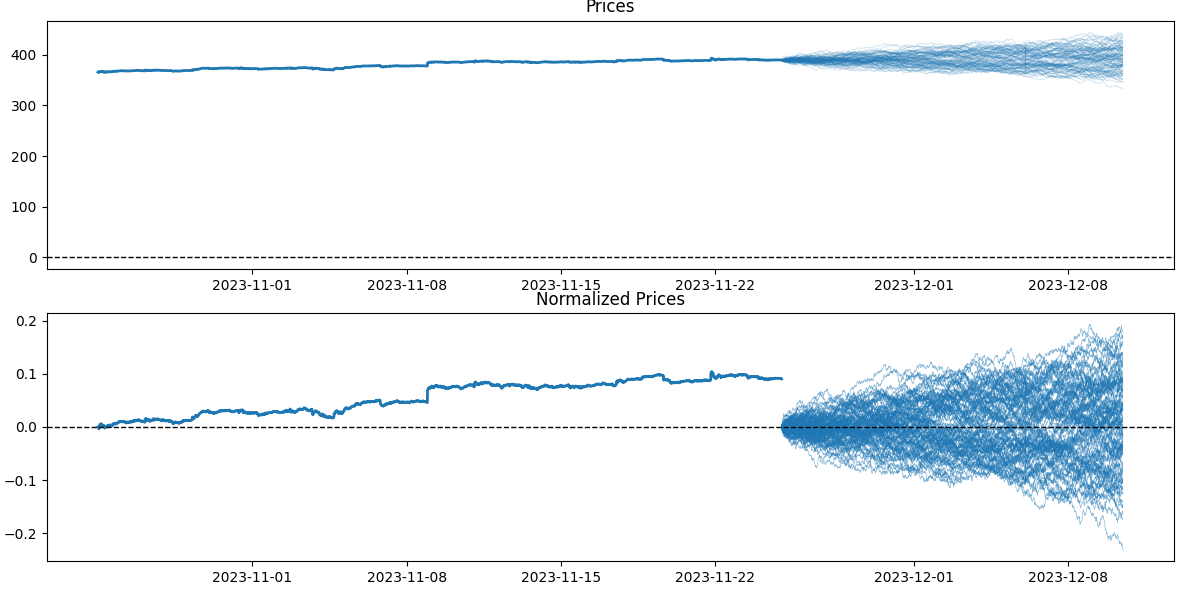

In [9]:
plt.close('all')
fig, axs = plt.subplots(2,1,figsize=(12, 6))
plt.tight_layout()

axs[0].set_title("Prices")
axs[1].set_title("Normalized Prices")

tickers = [
    # ['QQQ', '2021-03-01', '2021-09-01', '1d'],
    # ['QQQ', '2021-09-01', '2022-03-01', '1d'],
    # ['QQQ', '2022-03-01', '2022-09-01', '1d'],
    # ['QQQ', '2022-09-01', '2023-03-01', '1d'],
    # ['QQQ', '2023-03-01', '2023-09-01', '1d'],

    ['QQQ', '2023-10-25', '2023-11-25', '2m'],


    # ['YINN', '2021-03-01', '2021-09-01', '1d'],
    # ['YINN', '2021-09-01', '2022-03-01', '1d'],
    # ['YINN', '2022-03-01', '2022-09-01', '1d'],
    # ['YINN', '2022-09-01', '2023-03-01', '1d'],
    # ['YINN', '2023-03-01', '2023-09-01', '1d'],

    # ['VOO', '2023-01-01', '2023-12-01', '1h'],
    # ['YINN', '2015-01-01', '2015-12-01', '1d'],
    # ['O', '2016-01-01', '2016-12-01', '1d'],
    # ['O', '2023-09-01', '2023-12-01', '1h'],
]
for ticker in tickers:
    prices_raw = np.array(yf.Ticker(ticker[0]).history(start=ticker[1], end=ticker[2], interval=ticker[3])['Close'])
    prices_raw = prices_raw[~np.isnan(prices_raw)]

    print(f"{ticker}: {len(prices_raw)}")
    ticker_str = ticker[0]

    start_date = datetime.strptime(ticker[1], '%Y-%m-%d')
    end_date = datetime.strptime(ticker[2], '%Y-%m-%d')
    date_array = np.linspace(start_date.timestamp(), end_date.timestamp(), len(prices_raw))
    date_objects = [datetime.fromtimestamp(ts) for ts in date_array]
    date_objects_next = [datetime.fromtimestamp(ts)+(end_date-start_date) for ts in date_array]
    axs[0].plot(date_objects, prices_raw, label=ticker_str, linewidth=2)

    # prices = np.log2(prices_raw / prices_raw.mean())
    prices = np.log2(prices_raw / prices_raw[0])
    axs[1].plot(date_objects, prices, label=ticker_str, linewidth=2)

    nyquist_freq = (len(prices) // 2) + 1
    spectrum = np.fft.fft(prices)[:nyquist_freq]
    amplitudes = np.abs(spectrum)
    phases = np.angle(spectrum)


    for i in range(100):
        phases_sim = np.random.uniform(0, 2*pi, size=nyquist_freq)
        spectrum_sim = amplitudes * np.exp(1j * (phases_sim))
        prices_sim = np.fft.ifft(spectrum_sim).real

        # spectrum_sim[50:] = 0    #low pass filter
        if(len(prices)%2==0):
            spectrum_sim = np.concatenate((spectrum_sim[:-1], np.conj(spectrum_sim[-1:0:-1]))) #second half is the negative frequencies, reverse and remove last element, then take last element
        else:
            spectrum_sim = np.concatenate((spectrum_sim, np.conj(spectrum_sim[-1:0:-1])))
        prices_sim = np.fft.ifft(spectrum_sim).real

        # only the first half of the IFFT is reasonable
        halflen = len(prices_sim)//2
        date_objects_next = date_objects_next[:halflen]
        prices_sim = prices_sim[:halflen]

        prices_sim = (prices_sim - prices_sim[0])

        x = np.linspace(1e-6, pi/2, len(prices_sim))
        prices_sim = np.multiply(prices_sim, x/np.sin(x))

        color = axs[1].lines[-1].get_color()
        axs[1].plot(date_objects_next, prices_sim, label=i, linewidth=0.5, color=color, alpha=0.5)


        prices_predict = prices_raw[-1]*np.exp2(prices_sim)
        # prices_predict = prices_raw[-1]*np.power(3, prices_sim)
        axs[0].plot(date_objects_next, prices_predict, label=i, linewidth=0.5, color=color, alpha=0.2)
        
    axs[0].axhline(y=0, color='k', linestyle='--', linewidth=1)
    axs[1].axhline(y=0, color='k', linestyle='--', linewidth=1)
    # axs[0].legend()




(10, 1414)


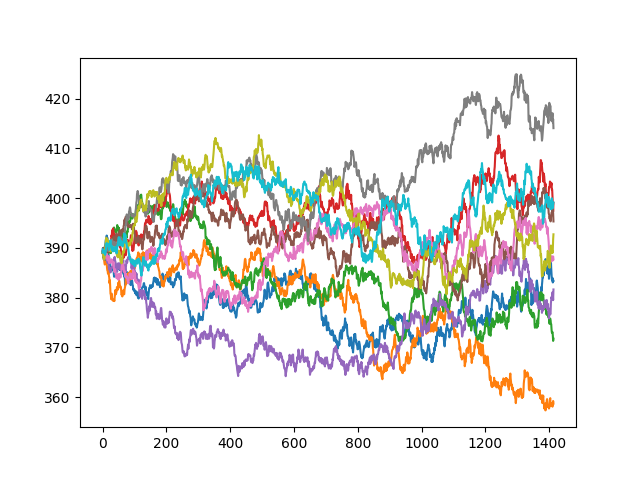

In [25]:
# file_name = max(glob.glob('./opt_saved/*.npy'), key=os.path.getctime) #latest updated file
# file_name = "./opt_saved/QQQ_2022-03-1_2022-09-01_1h_1000000n_2023-12-22_23-05-35.npy"
file_name = "./opt_saved/QQQ_2023-10-25_2023-11-25_2m_500000n_2023-12-22_22-49-42.npy"

all_sims = np.load(file_name) / 100
print(all_sims[:10].shape)
plt.figure()
plt.plot(all_sims[:10].T)
plt.show()

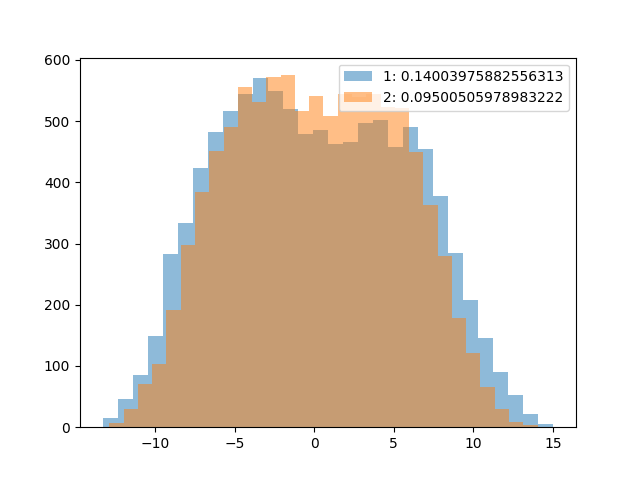

In [18]:
def run_grid_arr1(params, prices_arr):
    thresS, thresB, sell_max, buy_max = params
    (num_sims, price_len) = prices_arr.shape
    earned = np.zeros(num_sims)
    for sim_num in range(num_sims):
        P = prices_arr[sim_num]
        last_trans = P[0]
        shares = 0 #shares
        cash = 1
        for k in range(1,price_len):
            if(((P[k] - last_trans)/last_trans > thresS) and shares > 0):
                sell_amt = min(sell_max, shares*P[k])
                shares -= sell_amt/P[k]
                cash += sell_amt
                last_trans = P[k]
            if(((P[k] - last_trans)/last_trans < thresB or (shares <= 0 and (P[k]-P[k-1])/P[k-1] < thresB)) and cash > 0):
                buy_amt = min(buy_max, cash)
                shares += buy_amt/P[k]
                cash -= buy_amt
                last_trans = P[k]
        earned[sim_num] = 100*((cash + shares*P[-1]) - 1)
    return earned


def run_grid_arr2(params, prices_arr):
    thresS, thresB, sell_max, buy_max = params
    (num_sims, price_len) = prices_arr.shape
    earned = np.zeros(num_sims)
    for sim_num in range(num_sims):
        P = prices_arr[sim_num]
        last_trans = P[0]
        shares = 0 #shares
        cash = 1
        for k in range(1,price_len):
            if(((P[k] - last_trans)/last_trans > thresS) and shares > 0):
                sell_amt = min(sell_max, shares*P[k])
                shares -= sell_amt/P[k]
                cash += sell_amt
                last_trans = P[k]
            if(((P[k] - last_trans)/last_trans < thresB or (shares <= 0 and (P[k]-P[k-1])/P[k-1] < thresB)) and cash > 0):
                buy_amt = min(buy_max, cash)
                shares += buy_amt/P[k]
                cash -= buy_amt
                last_trans = P[k]
        earned[sim_num] = 100*((cash + shares*P[-1]) - 1)
    return earned

params = [0.06530, -0.00156, 0.17535, 0.17855,]
earned1 = run_grid_arr1(params, all_sims[:10000])

params = [0.05577, -0.00184, 0.18052, 0.09211,]
earned2 = run_grid_arr2(params, all_sims[:10000])

plt.figure()
plt.hist(earned1, bins=30, label=f'1: {earned1.mean()}', alpha=0.5)
plt.hist(earned2, bins=30, label=f'2: {earned2.mean()}', alpha=0.5)
plt.legend()
plt.show()



In [17]:
# np.set_printoptions(formatter={'all':lambda x: f'{x},'})
np.set_printoptions(formatter={'all':lambda x: f'{x:.5f},'})


NPARAMS = 4  # make this a 100-dimensinal problem.
NPOPULATION = 20  # use population size of 101.
MAX_ITERATION = 20  # run each solver for 5000 generations.
# guess = [
#     0.1/100,
#     -0.1/100,
#     0.1,
#     0.1
# ]
guess =   [0.05316, -0.00238, 0.11094, 0.03861,]



def fit_func(params):
    if(params[0] < 0 or params[1] > 0 or params[2] < 0 or params[3] < 0):
        return 0
    samples = np.random.choice(500000, 1000)
    return run_grid_arr1(params, all_sims[samples]).mean()

# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in range(MAX_ITERATION):
        solutions = solver.ask()

        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])

        solver.tell(fitness_list)
        result = solver.result()  # first element is the best solution, second element is the best fitness
        history.append(result)
        if (j + 1) % 1 == 0:
            print(
                "fitness at iteration",
                (j + 1),
                result[1],
                result[0],
                solver.rms_stdev(),
            )
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history


# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS, x0=guess, popsize=NPOPULATION, weight_decay=0.01, sigma_init=0.1)
cma_history = test_solver(cmaes)

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 4 (seed=384183, Fri Dec 22 22:54:28 2023)
fitness at iteration 1 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.07905169285660282
fitness at iteration 2 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.06522280813760235
fitness at iteration 3 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.06976849363421586
fitness at iteration 4 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.05655259474121329
fitness at iteration 5 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.06870539609095949
fitness at iteration 6 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.054573883621550176
fitness at iteration 7 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.05395193280802358
fitness at iteration 8 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.049714565128947896
fitness at iteration 9 0.3055890989900235 [0.05577, -0.00184, 0.18052, 0.09211,] 0.046580060601187

Traceback (most recent call last):
  File "/Users/chris/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_96504/826816484.py", line 52, in <module>
    cma_history = test_solver(cmaes)
                  ^^^^^^^^^^^^^^^^^^
  File "/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_96504/826816484.py", line 32, in test_solver
    fitness_list[i] = fit_func(solutions[i])
                      ^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_96504/826816484.py", line 22, in fit_func
    return run_grid_arr1(params, all_sims[samples]).mean()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_96504/2350627628.py", line -1, in run_grid_arr1
KeyboardInterrupt

During handling of the above exception, another 

buy 0.00023704257342875267 shares at 388.5799865722656 for -$0.09211, cash=0.91, invest=0.0 lasttrans: 388.5799865722656
buy 0.00023764803238033252 shares at 387.5899963378906 for -$0.09211, cash=0.82, invest=0.0 lasttrans: 387.5899963378906
buy 0.00023820114153056516 shares at 386.69000244140625 for -$0.09211, cash=0.72, invest=0.0 lasttrans: 386.69000244140625
buy 0.00023866156733031997 shares at 385.9440002441406 for -$0.09211, cash=0.63, invest=0.0 lasttrans: 385.9440002441406
buy 0.00023927782070172273 shares at 384.95001220703125 for -$0.09211, cash=0.54, invest=0.0 lasttrans: 384.95001220703125
buy 0.000239841676833365 shares at 384.0450134277344 for -$0.09211, cash=0.45, invest=0.0 lasttrans: 384.0450134277344
buy 0.0002403329271330135 shares at 383.260009765625 for -$0.09211, cash=0.36, invest=0.0 lasttrans: 383.260009765625
sell 0.0004452671921098315 shares at 405.41949462890625 for $0.18052, cash=0.54, invest=0.0 lasttrans: 405.41949462890625
buy 0.00022764552330495276 share

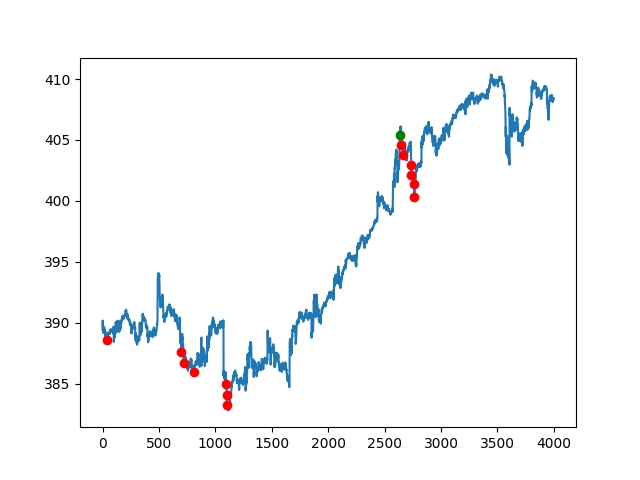

In [23]:
# params =  [0.14669, -0.00807, 0.23018, 0.18854,]
# params = [0.09908, -0.00147, 0.20335, 0.17750,]
# params =  [0.07198, -0.00420, 0.10617, 0.12786,]  #1h
params = [0.05577, -0.00184, 0.18052, 0.09211,]  #2m

thresS, thresB, sell_max, buy_max = params


ticker  = 'QQQ'
yfticker = yf.Ticker(ticker)
history_data = yfticker.history(period='1mo', interval='2m')
prices = np.array(history_data["Close"])
P = prices[~np.isnan(prices)]

# P = all_sims[0]

sell_log = []
buy_log = []

last_trans = P[0]
shares = 0 #shares
cash = 1
for k in range(1,len(P)):
    if(((P[k] - last_trans)/last_trans > thresS) and shares > 0):
        sell_amt = min(sell_max, shares*P[k])
        shares -= sell_amt/P[k]
        cash += sell_amt
        last_trans = P[k]
        sell_log.append(k)
        print(f"sell {sell_amt/P[k]} shares at {P[k]} for ${sell_amt}, cash={round(cash,2)}, invest={round(shares,2)} lasttrans: {last_trans}")
    if(((P[k] - last_trans)/last_trans < thresB or (shares <= 0 and (P[k]-P[k-1])/P[k-1] < thresB)) and cash > 0):
        buy_amt = min(buy_max, cash)
        shares += buy_amt/P[k]
        cash -= buy_amt
        last_trans = P[k]
        buy_log.append(k)
        print(f"buy {buy_amt/P[k]} shares at {P[k]} for -${buy_amt}, cash={round(cash,2)}, invest={round(shares,2)} lasttrans: {last_trans}")
earned = 100*((cash + shares*P[-1]) - 1)
print(f"earned: {earned}%")

base_return = 100 * (P[-1] / P[0] - 1)
print(f"base rate: {base_return}%")

plt.figure()
plt.plot(P)
for k in sell_log:
    plt.plot(k, P[k], 'go')
for k in buy_log:
    plt.plot(k, P[k], 'ro')

